In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# 读取数据
m=32561
def parse_line(line):
    """Parses a single line of the dataset."""
    parts = line.split()
    label = int(parts[0])
    features = {}
    for item in parts[1:]:
        index, value = item.split(':')
        features[int(index)] = int(value)
    return label, features

def load_dataset(filename):
    """Loads the dataset from a file."""
    labels = []
    features_list = []

    with open(filename, 'r') as file:
        for line in file:
            label, features = parse_line(line)
            labels.append(label)
            features_list.append(features)

    # Find the maximum index to determine the number of features
    max_index = max(max(features.keys()) for features in features_list)
    num_samples = len(labels)

    # Create a feature matrix with zeros
    feature_matrix = np.zeros((num_samples, max_index + 1), dtype=int)

    # Fill the feature matrix
    for i, features in enumerate(features_list):
        for index, value in features.items():
            feature_matrix[i, index] = value

    # Convert labels to a NumPy array
    labels = np.array(labels)
    return labels, feature_matrix

# Load the dataset
filename = 'a9a.txt'
labels, feature_matrix = load_dataset(filename)
labels=labels.reshape((m,1))
feature_matrix=feature_matrix[:,1:]

In [23]:
#一些函数
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def gradient(x,lam): 
  c = labels*(np.dot(feature_matrix,x).reshape((m,1)))
  p = (1-sigmoid(c))*labels
  gradient = (2*lam*x - np.dot(feature_matrix.T ,p) / m)
  return gradient

def Prox(x,mu):
  return np.sign(x)*np.maximum(np.abs(x)-mu,0)

def f(x,lam):
  c= labels*(np.dot(feature_matrix,x).reshape((m,1)))
  return np.sum(-np.log(sigmoid(c)))/m+lam*np.sum(x*x)

def lx(x,lam,mu):
  return f(x,lam)+mu*np.sum(np.abs(x))

In [24]:
#近似点梯度法
#lam为二范数约束的系数，mu为一范数罚项的系数，n为最多迭代步数，gamma为线搜索每次迭代的系数
#返回num为迭代次数，iteration为迭代过程矩阵，第k列为x_k,loss为|x_k-x_k-1|^2/t_k
def ProxGD(lam,mu,n,gamma=0.5,seed=42,accuracy=6):
  #初始化
  loss = np.zeros(n)
  iteration = np.zeros((123,n))
 
  num=0
  np.random.seed(seed)
  x1 = np.zeros(123).reshape((123,1))
  x2 = np.random.rand(123).reshape((123,1))
  t=1
  
  for k in range(n):
    x0=x1
    x1=x2
    # 线搜索
    grad1=gradient(x1,lam)
    x2=Prox(x1-t*grad1,t*mu)
    # t=np.dot((x1-x0).T,grad1-grad0)/np.sum((grad1-grad0)*(grad1-grad0))#BB步长
    while(f(x2,lam)>f(x1,lam)+np.dot(grad1.T,x2-x1)+1/(2*t)*np.sum((x2-x1)*(x2-x1))):
      t=gamma*t
      x2=Prox(x1-t*grad1,t*mu)

    loss[k]=np.sum((x1-x2)*(x1-x2))/t
    iteration[:,k]=x2[:,0]
    num=k
    if(np.log10(loss[k])<=-accuracy): 
      num=k 
      break

  return num,iteration[:,0:num+1],loss[0:num+1]


In [25]:
#FISTA算法
#lam为二范数约束的系数，mu为一范数罚项的系数，n为最多迭代步数，gamma为线搜索每次迭代的系数
#返回num为迭代次数，iteration为迭代过程矩阵，第k列为x_k,loss为|x_k-x_k-1|^2/t_k
def FISTA(lam,mu,n,gamma=0.5,seed=8,accuracy=6):
  #初始化
  loss = np.zeros(n)
  iteration = np.zeros((123,n))
  num=0
  np.random.seed(seed)
  x1 = np.zeros(123).reshape((123,1))
  x2 = np.random.rand(123).reshape((123,1))
  t = 1
  for k in range(n):
    x0=x1
    x1=x2
    y=x1+(k-2)/(k+1)*(x1-x0)
    
    # 线搜索
    grad=gradient(y,lam)
    x2=Prox(y-t*grad,t*mu)
    # t=np.dot((x1-x0).T,grad1-grad0)/np.sum((grad1-grad0)*(grad1-grad0))#BB步长
    while(f(x2,lam)>f(y,lam)+np.dot(grad.T,x2-y)+1/(2*t)*np.sum((x2-y)*(x2-y))):
      t=gamma*t
      x2=Prox(y-t*grad,t*mu)

    loss[k]=np.sum((x1-x2)*(x1-x2))/t
    iteration[:,k]=x2[:,0]
    num=k
    if(np.log10(loss[k])<=-accuracy): 
      break
  
  return num,iteration[:,0:num+1],loss[0:num+1]
  


<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PC-1\AppData\Local\Temp\ipykernel_42128\973873774.py:17: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log \|X_k-X_{k-1}\|^2 / t_k$')
C:\Users\PC-1\AppData\Local\Temp\ipykernel_42128\973873774.py:34: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log (L(x_t)-L(x_*))$')


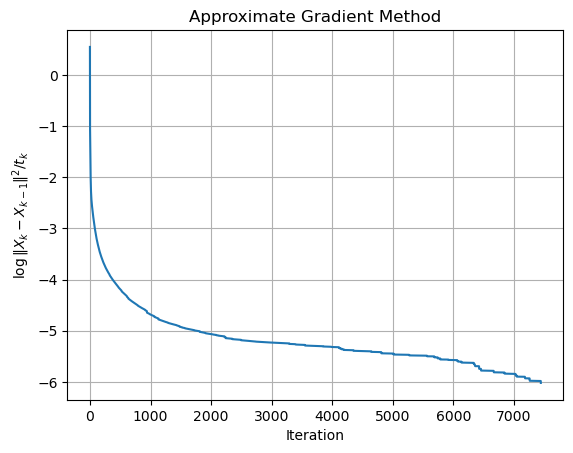

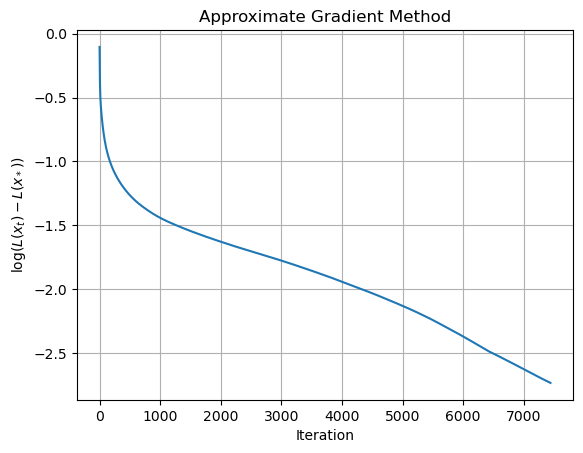

7442


In [26]:
# 近似点梯度法的收敛性实验
lam=1/(2*m)
mu=0.001
file_path = 'solution.txt'

solution = np.loadtxt(file_path)
lxsol=lx(solution.reshape((123,1)),lam,mu)

num,iteration,loss=ProxGD(1/(2*m),0.001,10000,accuracy=6,seed=3,gamma=0.1)
loss1=np.zeros(num+1)
x = range(num+1)
# print(x2)
# 绘制折线图
plt.plot(x, np.log10(loss))
plt.title('Approximate Gradient Method')
plt.xlabel('Iteration')
plt.ylabel('$\log \|X_k-X_{k-1}\|^2 / t_k$')
plt.grid(True)  # 添加网格线
plt.savefig("AGD-1",dpi=300)
plt.show()

x = range(num)

for i in range(num):
  # print(i)
  # print(iteration[:,i].shape)
  # print(iteration[:,i].reshape((123,1)).shape)
  loss1[i]=np.log10(lx(iteration[:,i].reshape((123,1)),lam,mu)-lxsol)
  # -lx(solution.reshape((123,1)),lam,mu)

plt.plot(x, loss1[0:num])
plt.title('Approximate Gradient Method')
plt.xlabel('Iteration')
plt.ylabel('$\log (L(x_t)-L(x_*))$')
plt.grid(True)  # 添加网格线
plt.savefig('AGD-2',dpi=300)
plt.show()

print(num)
np.savetxt("Prox1",loss)
np.savetxt("Prox2",loss1)



In [38]:
# FISTA算法的收敛性实验
lam=1/(2*m)
mu=0.001
file_path = 'solution.txt'
solution = np.loadtxt(file_path)
num,iteration,loss=FISTA(1/(2*m),0.001,10000,seed=3,accuracy=6,gamma=0.1)
lxsol=lx(solution.reshape((123,1)),lam,mu)
# np.savetxt(file_path,iteration[:,num])

loss1=np.zeros(num+1)
x = range(num+1)
# 绘制折线图
plt.plot(x, np.log10(loss))
plt.title('FISTA')
plt.xlabel('Iteration')
plt.ylabel('$\log \|X_k-X_{k-1}\|^2 / t_k$')
plt.grid(True) 
plt.savefig("FISTA-1",dpi=300)
plt.show()
lam=1/(2*m)
mu=0.001

for i in range(num+1):
  loss1[i]=np.log10((lx(iteration[:,i].reshape((123,1)),lam,mu)-lxsol))

plt.plot(x, loss1[0:num+1])
plt.title('FISTA')
plt.xlabel('Iteration')
plt.ylabel('$\log (L(x_t)-L(x_*))$')
plt.grid(True)  # 添加网格线
plt.savefig("FISTA-2",dpi=300)
plt.show()
# print(num)

np.savetxt("FISTA1",loss)
np.savetxt("FISTA2",loss1)


<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PC-1\AppData\Local\Temp\ipykernel_42128\2876748877.py:16: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log \|X_k-X_{k-1}\|^2 / t_k$')
C:\Users\PC-1\AppData\Local\Temp\ipykernel_42128\2876748877.py:29: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log (L(x_t)-L(x_*))$')
C:\Users\PC-1\AppData\Local\Temp\ipykernel_42128\2876748877.py:16: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log \|X_k-X_{k-1}\|^2 / t_k$')
C:\Users\PC-1\AppData\Local\Temp\ipykernel_42128\2876748877.py:29: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log (L(x_t)-L(x_*))$')


FileNotFoundError: solution.txt not found.

In [28]:
#比较mu的选取对结果的影响
result = {
    'mu': [0,1e-5,1e-4,1e-3, 0.01, 0.05],
    'sparsity': [0,0,0,0, 0,  0],
    'Iteration': [0,0,0,0, 0,  0]
}
result = pd.DataFrame(result)
lam=1/(2*m)
for i in range(6):
  num,iteration,loss=FISTA(lam,result.loc[i,'mu'],10000,seed=12)
  result.loc[i,'sparsity']=(123-np.count_nonzero(iteration[:,num]))/123
  result.loc[i,"Iteration"]=num+1
result.to_csv('result.txt', sep='\t', index=False)

C:\Users\PC-1\AppData\Local\Temp\ipykernel_42128\1241221575.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.10569105691056911' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[i,'sparsity']=(123-np.count_nonzero(iteration[:,num]))/123


In [29]:
#迭代过程中解的稀疏性变化
r=np.zeros((101,3))
x=range(0,100)
r[0,:]=[0.001,0.01,0.05]
plt.figure(figsize=(10, 6))
for i in range(3):
  num,iteration,loss=FISTA(lam,r[0,i],100,seed=12)
  for j in range(1,100):
    r[j,i]=np.count_nonzero(iteration[:,j-1])

r[0,:]=[123,123,123]
plt.plot(x, r[0:100,0].reshape((100,1)),label='0.001')
plt.plot(x, r[0:100,1].reshape((100,1)),label="0.01")
plt.plot(x, r[0:100,2].reshape((100,1)),label="0.05")
plt.title('Support Size')
plt.xlabel('Iteration')
plt.ylabel('Support Size')
plt.grid(True) 

legend = plt.legend()
legend.set_title('$\mu$')
plt.savefig("1",dpi=300)
plt.show()


<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
C:\Users\PC-1\AppData\Local\Temp\ipykernel_42128\2589276512.py:21: SyntaxWarning: invalid escape sequence '\m'
  legend.set_title('$\mu$')
C:\Users\PC-1\AppData\Local\Temp\ipykernel_42128\2589276512.py:21: SyntaxWarning: invalid escape sequence '\m'
  legend.set_title('$\mu$')


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:41: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:41: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PC-1\AppData\Local\Temp\ipykernel_42128\4168957133.py:25: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log \|X_k-X_{k-1}\|^2 / t_k$')
C:\Users\PC-1\AppData\Local\Temp\ipykernel_42128\4168957133.py:41: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log (L(x_t)-L(x_*))$')


7443
1248


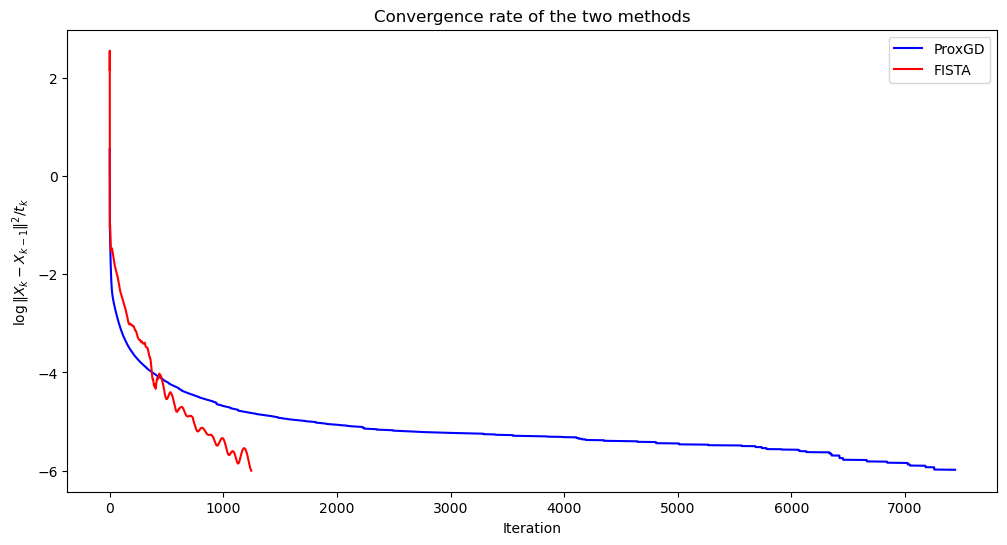

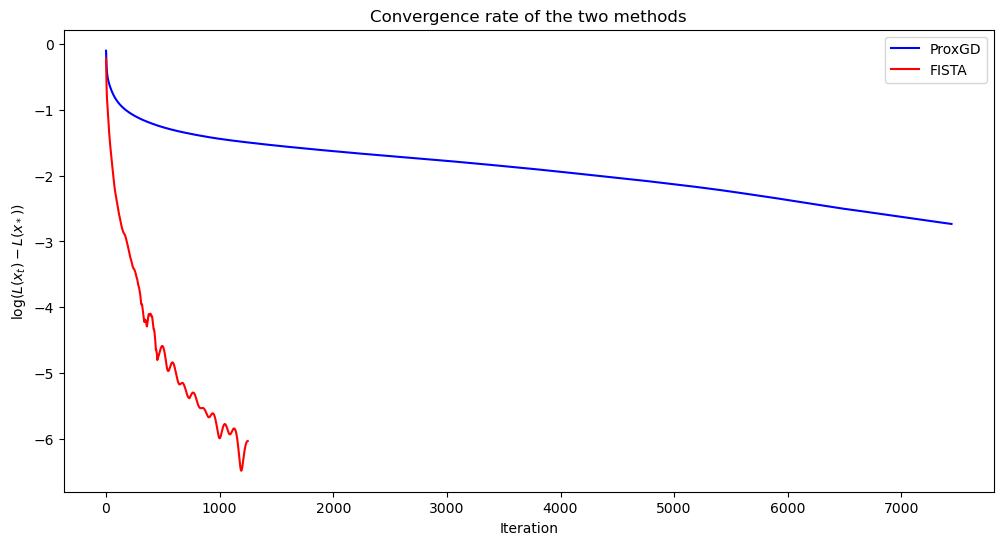

In [37]:
Prox1=np.loadtxt("Prox1")
Prox2=np.loadtxt("Prox2")

FISTA1=np.loadtxt("FISTA1")
FISTA2=np.loadtxt("FISTA2")

print(Prox1.size)
print(FISTA1.size)

import numpy as np
import matplotlib.pyplot as plt

# 创建x轴数据
x1 = np.arange(len(Prox1)-1)
x2 = np.arange(len(FISTA1))

# 创建图形
plt.figure(figsize=(12, 6))

plt.plot(x1, np.log10(Prox1[0:len(Prox1)-1]), label='ProxGD', color='b')
plt.plot(x2, np.log10(FISTA1), label='FISTA', color='r')
# 添加标题和标签
plt.title('Convergence rate of the two methods')
plt.xlabel('Iteration')
plt.ylabel('$\log \|X_k-X_{k-1}\|^2 / t_k$')

# 显示图例
plt.legend()
plt.savefig("C1",dpi=300)
# 显示图形
plt.show()


plt.figure(figsize=(12, 6))

plt.plot(x1, Prox2[0:len(Prox1)-1], label='ProxGD', color='b')
plt.plot(x2, FISTA2, label='FISTA', color='r')
# 添加标题和标签
plt.title('Convergence rate of the two methods')
plt.xlabel('Iteration')
plt.ylabel('$\log (L(x_t)-L(x_*))$')

# 显示图例
plt.legend()
plt.savefig("C2",dpi=300)
# 显示图形
plt.show()
